In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy
import sklearn
from scipy import stats
import tensorflow as tf

In [9]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100/4


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [10]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 1100)
dt = 0.001
epsilon = 0.01/2  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y

In [11]:
def autocorrelation_fft(data):
    data = data - np.mean(data)  # Remove the mean
    n = len(data)
    
    # Compute the power spectral density (PSD)
    data_fft = np.fft.fft(data, n=2*n)  # Zero-padding for avoiding circular convolution
    psd = np.abs(data_fft)**2
    
    # Compute the inverse Fourier transform of the PSD
    autocorr = np.fft.ifft(psd)
    
    # Keep only the positive lags and normalize the result
    autocorr = autocorr[:n].real
    autocorr /= autocorr[0]

    return autocorr

In [15]:
## The code below is used to generate the training data for the neural network

t_span = (0, 11000) # Time span
dt = 0.001  # Time step

t, y = euler_maruyama(initial_state, t_span, dt, epsilon)   # Solve the SDE
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# Extract the desired values
U = y[4]  # Extract U values
psi_e = y[0]  # Extract psi_e values
psi_p = y[2]  # Extract psi_p values

# Find the index corresponding to time t=100
start_index = int(100 / dt) 

# Slice arrays starting from the index of t=100
# t = t[start_index:]
# t = t - t[0]
# y = y[:, start_index:]
# U = U[start_index:]
# R = R[start_index:]
# psi_e = psi_e[start_index:]
# psi_p = psi_p[start_index:]

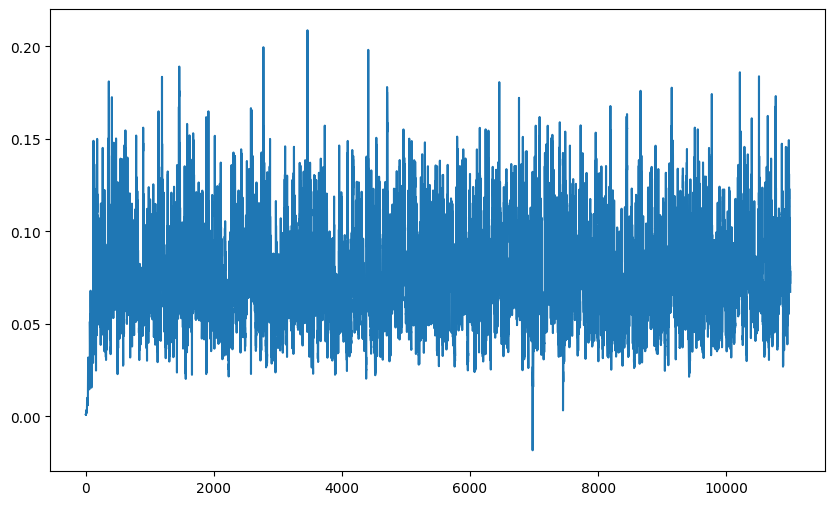

In [16]:
plt.figure(figsize=(10,6))
plt.plot(t,U)

In [26]:
np.mean(U)

0.07467394537880369

In [6]:
# Create a DataFrame with U and R
df = pd.DataFrame({'U': U, 'R': R})
df.to_csv('./data/train_data_longtime_210000.csv', index=False) #save the dataframe as a csv file

# save the variables t and y as a numpy array
np.savez('./data/train_data_numpy_longtime_210000.npz', t=t, y=y)

In [5]:
# load the variables t and y from the numpy file
data = np.load('./data/train_data_numpy_longtime_210000.npz')
t = data['t']
y = data['y']
U = y[4]  # Extract U values
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2]

# From the data created by the simulation, we calculate the conditional probability P(R|U) using a 2D histogram

In [18]:
# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U.min(), U.max(), num_bins)

r_bins = np.linspace(R.min(), -R.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, r_edges = np.histogram2d(U, R, bins=[u_bins, r_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)


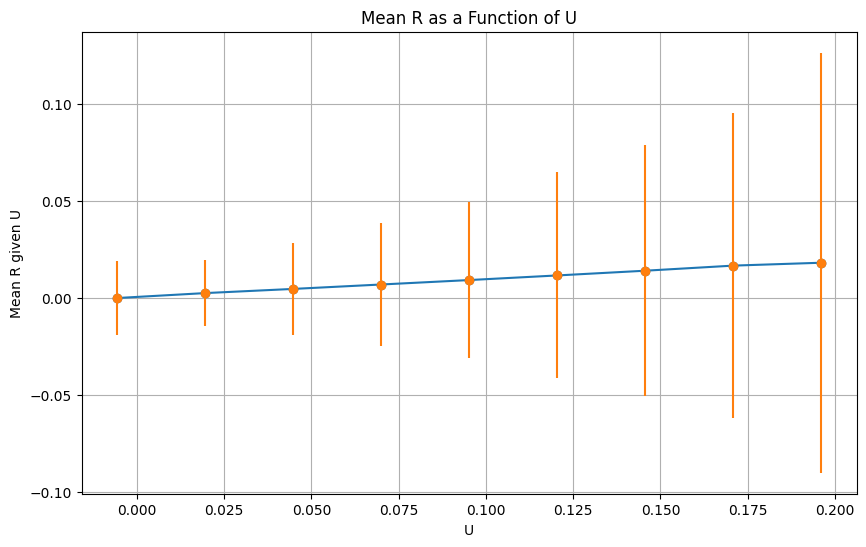

In [19]:
# First, compute the center of each R bin
r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

# Initialize an array to store the mean R for each U bin
mean_R_given_U = np.zeros(p_r_given_u.shape[0])
std_R_given_U = np.zeros(p_r_given_u.shape[0])

# Loop over each U bin
for i in range(p_r_given_u.shape[0]):
    
    # Compute the weighted average of R for this U bin
    mean_R_given_U[i] = np.sum(r_centers * p_r_given_u[i,:])
    std_R_given_U[i] = np.sqrt(np.sum((r_centers - mean_R_given_U[i])**2 * p_r_given_u[i,:]))

# Now, compute the center of each U bin
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])

# Plot mean R as a function of U
plt.figure(figsize=(10,6))
plt.plot(u_centers, mean_R_given_U ,'-', marker='o')
# plot the error bars (1 standard deviation)
plt.errorbar(u_centers, mean_R_given_U, yerr=std_R_given_U, fmt='o')
plt.xlabel('U')
plt.ylabel('Mean R given U')
plt.title('Mean R as a Function of U')
plt.grid(True)
plt.show()

In [20]:
# Binning the U values
U_bin_number = np.digitize(U, u_bins)

# Initialize empty arrays to store the R values for each U bin
R_values_in_bins = [[] for _ in range(num_bins)]

# Loop over the U and R data
for i in range(len(U)):
    
    # Get the bin number for this U value
    bin_number = U_bin_number[i] - 1  # subtract 1 because np.digitize bins are 1-indexed
    if bin_number==9:
        bin_number=8
    
    # Append the corresponding R value to the appropriate bin
    if bin_number < num_bins:  # ignore U values that fall in the overflow bin
        R_values_in_bins[bin_number].append(R[i])

# Now you have lists of R values for each U bin
# You could convert these lists to numpy arrays if you want to perform numpy operations on them
R_values_in_bins = [np.array(bin_values) for bin_values in R_values_in_bins]

In [21]:
R_values_in_bins = R_values_in_bins[0:9]

In [22]:
R_mean_in_bins = np.zeros(len(R_values_in_bins))
R_std_in_bins = np.zeros(len(R_values_in_bins))
R_sem_in_bins = np.zeros(len(R_values_in_bins))
R_var_in_bins = np.zeros(len(R_values_in_bins))

In [23]:
for i in range(len(R_mean_in_bins)):

    R_mean_in_bins[i] = np.mean(R_values_in_bins[i])
    R_std_in_bins[i] = np.std(R_values_in_bins[i])
    R_sem_in_bins[i] = R_std_in_bins[i]/np.sqrt(len(R_values_in_bins[i]))
    R_var_in_bins[i] = R_std_in_bins[i]**2

print(R_mean_in_bins)
print(R_std_in_bins)
print(R_sem_in_bins)
print(R_var_in_bins)

[0.0005155  0.00276565 0.0048086  0.00701316 0.00929621 0.01168336
 0.01403991 0.01674495 0.01863893]
[0.01917503 0.01669667 0.02315104 0.0310758  0.03997102 0.05276962
 0.06430178 0.07839983 0.10788356]
[1.14347928e-04 3.84745420e-05 1.50454926e-05 1.44522610e-05
 2.35776893e-05 6.03186540e-05 1.75710886e-04 5.94501328e-04
 2.65913469e-03]
[0.00036768 0.00027878 0.00053597 0.00096571 0.00159768 0.00278463
 0.00413472 0.00614653 0.01163886]


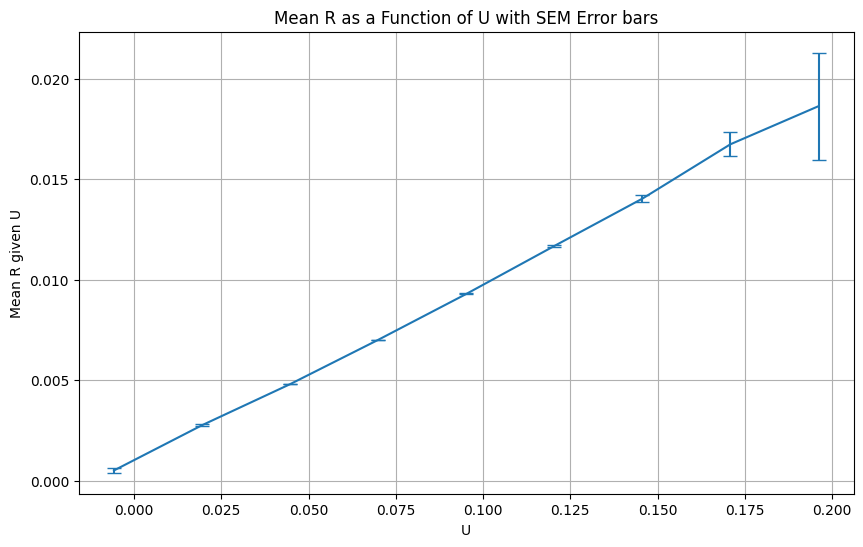

In [24]:
plt.figure(figsize=(10,6))
plt.errorbar(u_centers, R_mean_in_bins, yerr=R_sem_in_bins, fmt='-', capsize=5)
plt.xlabel('U')
plt.ylabel('Mean R given U')
plt.title('Mean R as a Function of U with SEM Error bars')
plt.grid(True)
plt.show()

In [25]:
with open("variables_2D_hist_2.pickle", "wb") as f:
    pickle.dump((u_centers, R_mean_in_bins, std_R_given_U, R_sem_in_bins), f)